# Pass Coverage Classification - A Supervised Approach

------------------------------------------------------------------------------------------------------------

# Introduction

For this submission, we want to identify Man/Zone coverage probabilities throughout the play for cornerbacks using a MLP Model based approach for each event partition throughout the play. Then based on the probabilities of the defenders, we can also determine the coverage scheme for the entire play.

This is a different approach compared to the one proposed in this [paper](https://arxiv.org/pdf/1906.11373.pdf) by Rishav Dutta, Ronald Yurko, Samuel Ventura and @AndikaRachman's rendition of ["Identifying Coverage Scheme Among Defensive Backs"](https://www.kaggle.com/ar2017/identifying-coverage-scheme-among-defensive-backs) submission. Both use a Gaussian Mixture Model to determine coverage probabilities, however, the lack of labels in unsupervised models make it difficult to see how well the model actually did. Luckily, @tombliss's [notebook](https://www.kaggle.com/tombliss/additional-data-coverage-schemes-for-week-1) and Telemetry sports gifted us coverage data for nearly all week 1 plays.

---------------------------------------------------------------------------------------------------------------------------------------------------------

# Player Orientation

First I want to address the "Discussion and Future Work" portion of Rishav Dutta, Ronald Yurko, and Samuel Ventura's paper. They proposed that orientation of the defender could be a key metric when determining defensive coverage, unfortunately they didn't have access to that data at the time. 

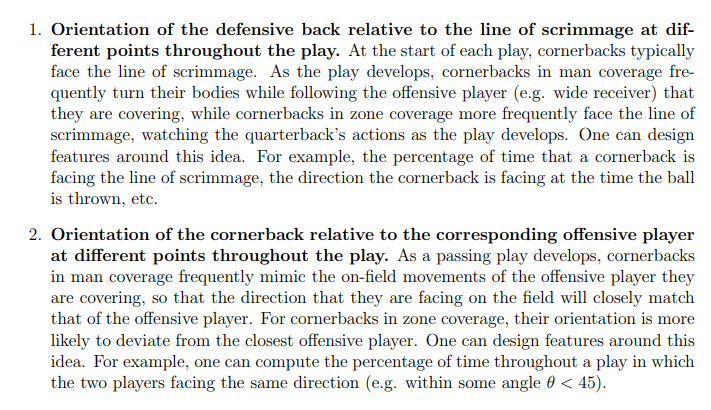

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
pd.set_option('max_columns', 1000)
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import datetime
import pytz
from IPython.display import HTML
import scipy.stats as stats
import matplotlib as mpl
from matplotlib import animation, rc, use
from matplotlib.patches import Rectangle, Arrow
import tensorflow as tf
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import gc


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    return df


def get_dx_dy(radian_angle, dist):
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy


def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='slategrey', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.3,
                                edgecolor='k',
                                facecolor='royalblue',
                                alpha=0.4,
                                zorder=1)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.3,
                                edgecolor='k',
                                facecolor='royalblue',
                                alpha=0.4,
                                zorder=1)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(0, 53.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax



class CreateNFLData:

    def __init__(self):
        pass

    def LoadData(self, Normal=True):
        if Normal == True:
            print("Loading Original Data")
            globbed_files = glob.glob("week*.csv") #creates a list of all csv files
            data = []
            for csv in tqdm(globbed_files):
                frame = pd.read_csv(csv, index_col=0)
                data.append(frame)

            WeekData = pd.concat(data).reset_index()
            WeekData
        
        else:
            print("Loading Modified Data")
            globbed_files = glob.glob("Revised Data/*.csv") #creates a list of all csv files
            data = []
            for csv in tqdm(globbed_files):
                frame = pd.read_csv(csv, index_col=0)
                data.append(frame)

            WeekData = pd.concat(data).reset_index()
            WeekData
        return WeekData



    
    def FrameData(self,WeekData1):
        NotNone = WeekData1.query('event != "None"')
        NotNone = NotNone.groupby(['gameId','playId','event'])['frameId'].max().reset_index()
        NotNone = NotNone.set_index(['gameId','playId','event'], drop= True).unstack('event').reset_index()
        NotNone.columns = [' '.join(col).strip() for col in NotNone.columns.values]
        NotNone.columns = NotNone.columns.str.replace('frameId' , '')
        NotNone.columns = NotNone.columns.str.replace(' ' , '')
        NotNone['Code'] = NotNone['gameId'].astype(str) + "-" + NotNone['playId'].astype(str)
        NotNone = NotNone.set_index('Code')
        NotNone = NotNone.loc[~NotNone.index.duplicated(keep='first')]

        for col in tqdm(NotNone.columns):
            NotNone['Contains_' + str(col)] = np.where(NotNone[col] > 0, True, False)

        Cols = ['ball_snap', 'man_in_motion', 'pass_arrived', 'pass_forward','pass_outcome_caught', 'play_action', 'run_pass_option', 'Contains_man_in_motion', 'Contains_pass_arrived', 'Contains_pass_forward', 'Contains_pass_outcome_caught', 'Contains_play_action','Contains_run_pass_option']
    #   WeekData1 = pd.merge(df, NotNone, how="left", left_on=['gameId','playId'], right_on=['gameId','playId'] )
        for col in Cols:
            WeekData1[col] = WeekData1.Code.map(NotNone[col])

        del NotNone
        gc.collect()

        WeekData1['After_snap'] = np.where(WeekData1['frameId'] > WeekData1['ball_snap'],1,0)
        WeekData1['After_Throw'] = np.where(WeekData1['frameId'] > WeekData1['pass_forward'],1,0)
        WeekData1['After_PassArrived'] = np.where(WeekData1['frameId'] > WeekData1['pass_arrived'],1,0)
        WeekData1['After_PlayAction'] = np.where(WeekData1['frameId'] > WeekData1['play_action'],1,0)
    #   WeekData1['After_run_pass_option'] = np.where(WeekData1['frameId'] > WeekData1['run_pass_option'],1,0)
        WeekData1['After_Catch'] = np.where(WeekData1['frameId'] > WeekData1['pass_outcome_caught'],1,0)

        
        LOS = WeekData1.query('displayName == "Football" & After_snap == 0')
        LOS = LOS.groupby(['gameId','playId'])['X_std'].agg('median').reset_index()
        LOS.columns = ['gameId','playId','LOS']
        LOS['Code'] = LOS['gameId'].astype(str) + "-" + LOS['playId'].astype(str)
        LOS = LOS.set_index('Code')
        LOS = LOS.loc[~LOS.index.duplicated(keep='first')]
        WeekData1["LOS"] = WeekData1.Code.map(LOS['LOS'])
        WeekData1['Distfrom_LOS'] = WeekData1['X_std'] - WeekData1['LOS']
        WeekData1['AbsDistfrom_LOS'] = np.abs(WeekData1['X_std'] - WeekData1['LOS'])
        del LOS
        gc.collect()
        return WeekData1
    
    def import_data(self,file,columns=False,cols=""):
        """create a dataframe and optimize its memory usage"""
        if columns == False:
            df = pd.read_csv(file, low_memory=False)
            df = reduce_mem_usage(df)
        else:
            df = pd.read_csv(file, low_memory=False, usecols=cols)
            df = reduce_mem_usage(df)
        return df
    





class AnimatePlay:
    def __init__(self, play_df,player_id=[], Tri = False, MPH = False,Text="",Show='jerseyNumber',method='all' ) -> None:
        self._MAX_FIELD_Y = 53.3
        self._MAX_FIELD_X = 120
        self._MAX_FIELD_PLAYERS = 22
        

        self.Tri = Tri
        self.MPH = MPH
        self.player_id = player_id
        self.Show = Show
        self.method = method
        self.Text = Text

        self._CPLT = sns.color_palette("husl", 2)
        self._frame_data = play_df
        self._times = sorted(play_df.time.unique())
        self._stream = self.data_stream()
        
        self._date_format = "%Y-%m-%dT%H:%M:%S.%fZ" 
        self._mean_interval_ms = np.mean([delta.microseconds/1000 for delta in np.diff(np.array([pytz.timezone('US/Eastern').localize(datetime.strptime(date_string, self._date_format)) for date_string in self._times]))])
        
        self._fig, self._ax_field = create_football_field()

        self._fig.set_figheight(10)
        self._fig.set_figwidth(15)
        
        self._fig.tight_layout()
        
        self._ax_field = plt.gca()
        
        self._ax_home = self._ax_field.twinx()
        self._ax_away = self._ax_field.twinx()
        self._ax_jersey = self._ax_field.twinx()

        self.ani = animation.FuncAnimation(self._fig, self.update, frames=len(self._times), interval = self._mean_interval_ms, 
                                          init_func=self.setup_plot, blit=False)
        
        plt.close()
       
    @staticmethod
    def set_axis_plots(ax, max_x, max_y) -> None:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        ax.set_xlim([0, max_x])
        ax.set_ylim([0, max_y])
        
    @staticmethod
    def convert_orientation(x):
        return (-x + 90)%360
    
    @staticmethod
    def polar_to_z(r, theta):
        return r * np.exp( 1j * theta)
    
    @staticmethod
    def deg_to_rad(deg):
        return deg*np.pi/180
        
    def data_stream(self):
        for time in self._times:
            yield self._frame_data[self._frame_data.time == time]
    
    def setup_plot(self): 
        self.set_axis_plots(self._ax_field, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        
        ball_snap_df = self._frame_data[(self._frame_data.event == 'ball_snap') & (self._frame_data.team == 'football')]
        self._ax_field.axvline(ball_snap_df.X_std.to_numpy()[0], color = 'yellow', linestyle = '--')
        
        self.set_axis_plots(self._ax_home, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        self.set_axis_plots(self._ax_away, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        self.set_axis_plots(self._ax_jersey, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        
        for idx in range(10,120,10):
            self._ax_field.axvline(idx, color = 'k', linestyle = '-', alpha = 0.05)
            
        self._scat_field = self._ax_field.scatter([], [], s = 200, color = 'red')
        self._scat_home = self._ax_home.scatter([], [], s = 900, color = self._CPLT[0], edgecolors = 'k')
        self._scat_away = self._ax_away.scatter([], [], s = 900, color = self._CPLT[1], edgecolors = 'k')
        
        self._scat_jersey_list = []
        self._scat_number_list = []
        self._scat_name_list = []
        self._scat_mph_list = []
        self._a_dir_list = []
        self._a_or_list = []
        self._a_tri_list = []
        for _ in range(self._MAX_FIELD_PLAYERS):
            self._scat_jersey_list.append(self._ax_jersey.text(0, 0, '', horizontalalignment = 'center', verticalalignment = 'center', c = 'black',fontweight='bold',fontsize='large',path_effects=[pe.withStroke(linewidth=3, foreground="white")]))
            self._scat_number_list.append(self._ax_jersey.text(0, 0, '', horizontalalignment = 'center', verticalalignment = 'center', c = 'white',fontweight='bold',fontsize=14,path_effects=[pe.withStroke(linewidth=5, foreground="dodgerblue")]))
            self._scat_name_list.append(self._ax_jersey.text(0, 0, '', horizontalalignment = 'center', verticalalignment = 'center', c = 'black',fontweight='bold',fontsize='larger',path_effects=[pe.withStroke(linewidth=5, foreground="gold")]))
            self._scat_mph_list.append(self._ax_jersey.text(0, 0, '', horizontalalignment = 'center', verticalalignment = 'center', c = 'lime',fontweight='bold',fontsize='larger'))

            self._a_dir_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color = 'k')))
            self._a_or_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color = 'k')))
            self._a_tri_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color = 'k')))
            
        return (self._scat_field, self._scat_home, self._scat_away,*self._scat_mph_list, *self._scat_jersey_list, *self._scat_number_list, *self._scat_name_list)
        
    def update(self, anim_frame):
        pos_df = next(self._stream)
        
        for label in pos_df.team.unique():
            label_data = pos_df[pos_df.team == label]

            if label == 'football':
                self._scat_field.set_offsets(np.hstack([label_data.X_std, label_data.Y_std]))
            elif label == 'home':
                self._scat_home.set_offsets(np.vstack([label_data.X_std, label_data.Y_std]).T)
            elif label == 'away':
                self._scat_away.set_offsets(np.vstack([label_data.X_std, label_data.Y_std]).T)

        jersey_df = pos_df[pos_df.jerseyNumber.notnull()]
        
        for (index, row) in pos_df[pos_df.jerseyNumber.notnull()].reset_index().iterrows():
            self._scat_jersey_list[index].set_position((row.X_std, row.Y_std))
            self._scat_jersey_list[index].set_text(row.position)
            if self.method == 'single':
                try:
                    self._scat_number_list[index].set_text(np.where(np.isin(row.nflId,self.player_id) == True,str(self.Text) +" "+ str(round(row[self.Show],2)),""))
                    self._scat_number_list[index].set_position((row.X_std, row.Y_std+2.4))
                except:
                    self._scat_number_list[index].set_text(np.where(np.isin(row.nflId,self.player_id) == True,str(self.Text) +" "+ str(row[self.Show]),""))
                    self._scat_number_list[index].set_position((row.X_std, row.Y_std+2.4))
                    pass
            else:
                try:
                    self._scat_number_list[index].set_text(str(round(row[self.Show],2)))
                    self._scat_number_list[index].set_position((row.X_std, row.Y_std+2.4))
                except:
                    self._scat_number_list[index].set_text(row[self.Show])
                    self._scat_number_list[index].set_position((row.X_std, row.Y_std+2.4))
                    pass               

            self._scat_name_list[index].set_text(np.where(row.frameId <= 10,row.displayName.split()[-1],""))
            self._scat_name_list[index].set_position((row.X_std, row.Y_std-1.9))
            if self.MPH == True:
                self._scat_mph_list[index].set_text(np.where((row.s / 0.488889) > 17,str(round(float(row.s / 0.488889),2)) + " MPH",""))
                self._scat_mph_list[index].set_position((row.X_std, row.Y_std+1.9))
            else:
                pass

            player_vel = np.array([row.dx, row.dy])
            player_orient = np.array([np.real(self.polar_to_z(3, row.Orientation_std)), np.imag(self.polar_to_z(3, row.Orientation_std))])
            
            self._a_dir_list[index].remove()
            self._a_dir_list[index] = self._ax_field.add_patch(Arrow(row.X_std, row.Y_std, player_vel[0], player_vel[1], color = 'black'))
            
            self._a_or_list[index].remove()
            self._a_or_list[index] = self._ax_field.add_patch(Arrow(row.X_std, row.Y_std, player_orient[0], player_orient[1], color = 'blue', width = 2))

            if self.Tri == True:
                if (self.method == 'single') & (np.isin(row.nflId,self.player_id) == True):
                    self._a_tri_list[index].remove()
                    self._a_tri_list[index] = self._ax_field.add_patch(Polygon([[row.X_std, row.Y_std], [row.X_std_COpp,row.Y_std_COpp],[row.X_std_QB,row.Y_std_QB]], closed=True, fill=False, hatch='/',color='lime'))
                else:
      #              self._a_tri_list[index].remove()
      #              self._a_tri_list[index] = self._ax_field.add_patch(Polygon([[row.X_std, row.Y_std], [row.X_std_COpp,row.Y_std_COpp],[row.X_std_QB,row.Y_std_QB]], closed=True, fill=False, hatch='/',color='lime'))
                    pass
            else:
                pass
        
        return (self._scat_field, self._scat_home, self._scat_away, *self._scat_jersey_list, *self._scat_number_list, *self._scat_name_list)

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
pd.set_option('max_columns', 1000)

from sklearn.neighbors import BallTree

#from BDBUtils.Utilities import CreateNFLData
from IPython.core.display import HTML
import time
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import datetime
import pytz
from IPython.display import HTML
import scipy.stats as stats
import matplotlib as mpl
from matplotlib import animation, rc
from matplotlib.patches import Rectangle, Arrow
import tensorflow as tf
#from BDBUtils.Utilities import CreateNFLData

import glob
import os

np.set_printoptions(suppress=True)

import gc

def convert_orientation(x):
    return (x)%360

def deg_to_rad(deg):
        return deg*np.pi/180



Create = CreateNFLData()

start = time.process_time()

Weeks = [1,2,3,10]

#globbed_files = glob.glob("../input/revised-data/*.csv") #creates a list of all csv files
data = []
for n in tqdm(Weeks):
    filename = '../input/revised-data/week' + str(n) + '.csv'
    frame = Create.import_data(filename)
    frame['Code'] = frame['gameId'].astype(str) + "-" + frame['playId'].astype(str)
    plays = pd.read_csv('../input/nfl-big-data-bowl-2021/plays.csv', usecols=['gameId', 'playId','down', 'yardsToGo','penaltyCodes', 'penaltyJerseyNumbers', 'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI','offenseFormation',	'personnelO',	'defendersInTheBox',	'numberOfPassRushers',	'personnelD',	'typeDropback','playType'])
    plays['Code'] = plays['gameId'].astype(str) + "-" + plays['playId'].astype(str)
    plays = plays.set_index('Code')
    plays = plays.loc[~plays.index.duplicated(keep='first')]
    Cols = ['playId','down', 'yardsToGo','penaltyCodes', 'penaltyJerseyNumbers', 'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI','offenseFormation',	'personnelO',	'defendersInTheBox',	'numberOfPassRushers',	'personnelD',	'typeDropback','playType']
    for col in Cols:
        frame[col] = frame.Code.map(plays[col])
    data.append(frame)
    del plays
    gc.collect()
    del frame
    gc.collect()

WeekData = pd.concat(data).reset_index()
del data
gc.collect()
Finaldf1 = Create.FrameData(WeekData)
del WeekData
gc.collect()
Finaldf1.drop(['index','Code','IsOnOffense', 'ball_snap', 'man_in_motion', 'pass_arrived', 'pass_forward', 'pass_outcome_caught', 'play_action', 'run_pass_option'], axis=1, inplace=True)
Finaldf1.memory_usage().sum() / (1024**2)

gc.collect()
Finaldf1.memory_usage().sum() / (1024**2)

Finaldf1['QBslope'] = deg_to_rad(convert_orientation(np.rad2deg(np.arctan2(Finaldf1['Y_std_QB'] - Finaldf1['Y_std'], Finaldf1['X_std_QB'] - Finaldf1['X_std']))))
Finaldf1['WRslope'] = deg_to_rad(convert_orientation(np.rad2deg(np.arctan2(Finaldf1['Y_std_COpp'] - Finaldf1['Y_std'],Finaldf1['X_std_COpp'] - Finaldf1['X_std']))))

Finaldf1['QBslope1'] = convert_orientation(np.rad2deg(np.arctan2(Finaldf1['Y_std_QB'] - Finaldf1['Y_std'], Finaldf1['X_std_QB'] - Finaldf1['X_std'])))
Finaldf1['WRslope1'] = convert_orientation(np.rad2deg(np.arctan2(Finaldf1['Y_std_COpp'] - Finaldf1['Y_std'],Finaldf1['X_std_COpp'] - Finaldf1['X_std'])))
Finaldf1['Def_Or'] = convert_orientation(np.rad2deg(Finaldf1['Orientation_std']))
Finaldf1['Diff_QB'] = Finaldf1['QBslope1'] - Finaldf1['Def_Or']
Finaldf1['Diff_WR'] = Finaldf1['WRslope1'] - Finaldf1['Def_Or']

Finaldf1['Diff_QB'] = abs(np.where(Finaldf1['Diff_QB'] < -180,Finaldf1['Diff_QB'] + 360,Finaldf1['Diff_QB'] ))
Finaldf1['Diff_QB'] = abs(np.where(Finaldf1['Diff_QB'] > 180,Finaldf1['Diff_QB'] - 360,Finaldf1['Diff_QB'] ))

Finaldf1['Diff_WR'] = abs(np.where(Finaldf1['Diff_WR'] < -180,Finaldf1['Diff_WR'] + 360,Finaldf1['Diff_WR'] ))
Finaldf1['Diff_WR'] = abs(np.where(Finaldf1['Diff_WR'] > 180,Finaldf1['Diff_WR'] - 360,Finaldf1['Diff_WR'] ))

Finaldf1['Player_POV'] = np.where(Finaldf1['Diff_QB'] < Finaldf1['Diff_WR'],"QB",Finaldf1['position_COpp'])
Finaldf1['Looking_AtQB'] = np.where(Finaldf1['Diff_QB'] < Finaldf1['Diff_WR'],1,0)

Finaldf1['diffDir'] = np.absolute(Finaldf1['Dir_std'] - Finaldf1['Dir_std_COpp'])

Finaldf1['disRatio'] = Finaldf1['Opp_Dist_COpp'] / np.sqrt((Finaldf1['X_std_COpp'] - Finaldf1['X_std_CTm'])**2 + (Finaldf1['Y_std_COpp'] - Finaldf1['Y_std_CTm'])**2)

Finaldf1['Event2'] = np.where(Finaldf1['After_snap'] == 0,"Before Snap","After Snap - Before Throw")
Finaldf1['Event2'] = np.where((Finaldf1['After_Throw'] == 1 & (Finaldf1['After_PassArrived'] == 0)),"Ball in the Air", Finaldf1['Event2'])

Finaldf1['EventCount'] = Finaldf1.groupby(['gameId','playId','Event2'])['Event2'].transform('count') / Finaldf1.groupby(['gameId','playId'])['nflId'].transform('nunique')
Finaldf1['EventOrder'] = Finaldf1.groupby(['gameId','playId','Event2'])['frameId'].rank(ascending=True, method='dense').astype(int)
Finaldf1['EventPct'] = Finaldf1['EventOrder'] / Finaldf1['EventCount']

Finaldf1['Partition'] = np.where(Finaldf1['EventPct'] > (1/2), "2nd Phase", "1st Phase")

Finaldf1['Group'] = Finaldf1['Event2'] + "-" + Finaldf1['Partition']


------------------------------------------------------------------------------------------------

# Figuring Out Orientation

Using some magical geometry techniques we can determine where the cornerback is looking throughout the play.

All we need is: 

* Defender's Orientation
* Defender's X and Y coordinates
* Closest Offensive Player's X and Y coordinates
* Quarterback's X and Y coordinates

The coordinate metrics will help us form a triangle on the field, and the defenders orientation will be the needle that either approaches the quarterback's slope side of the triangle, or the closest opposing offensive player's slope side.

Let's take a look:

In [ ]:
import math
#from BDBUtils.Utilities import AnimatePlay
sns
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
pd.set_option('max_columns', 1000)

pd.options.display.float_format = '{:.3f}'.format

gId = 2018110800	
pId = 274
nflId = [2560753,2555175]

ex = Finaldf1.query('gameId == @gId & playId == @pId')

One = ex.query('displayName == "Donte Jackson" | OnOffense == True | displayName == "Football"')
One = One.query('After_PassArrived == 0')

from matplotlib.patches import Polygon

del ex
gc.collect()

animated_play = AnimatePlay(One,player_id=nflId, Tri = True, MPH = False,Text="POV:",Show='Player_POV',method='single' )
HTML(animated_play.ani.to_jshtml())

You can see cornerback Donte Jackson starts the play looking at the Quarterback, but then immediately turns to face the WR and continued to do so for the rest of the play and we were able to capture that.

* POV = "Point of View" + the position of the player he's looking at
* Blue Arrows = Where the defender is looking
* Black Arrows = The direction the defender is moving
* Green Triangle = The triangle formed from the coordinates of the Defender, the closest offensive player at all times, and the Quarterback

The same can be applied to James Bradberry on the other side.

In [ ]:
gId = 2018110800	
pId = 274
nflId = [2560753,2555175]

ex = Finaldf1.query('gameId == @gId & playId == @pId')

One = ex.query('displayName == "James Bradberry" | OnOffense == True | displayName == "Football"')
One = One.query('After_PassArrived == 0')

from matplotlib.patches import Polygon

del ex
gc.collect()

animated_play = AnimatePlay(One,player_id=nflId, Tri = True, MPH = False,Text="POV:",Show='Player_POV',method='single' )
HTML(animated_play.ani.to_jshtml())

# The Variables

Now that we have orientation figured out, we will use some of the same variables in the paper including a couple more.

* X_Var - Variance of X Coordinate

* Y_Var - Variance of Y Coordinate

* S_var - Variance of Speed

* Vardx - Variance of X Velocity

* Vardy - Variance of Y Velocity

* oppMean - Closest Opp. Distance Mean

* oppVar - Closest Opp. Distance Var

* mateMean - Closest Teammate Distance Mean

* mateVar - Closest Teammate Distance Var

* oppDirVar - Difference in Closest Opp. Direction Variance

* oppDirMean - Difference in Closest Opp. Direction Mean

* ratVar - Ratio of the distance to the nearest opponent, and the distance from the nearest opponent to the nearest teammate Variance

* ratMean - Ratio of the distance to the nearest opponent, and the distance from the nearest opponent to the nearest teammate Mean

* DiffO_mean - Orientation difference in Closest Opp. mean

* DiffO_var - Orientation difference in Closest Opp. variance

* Diff_QBmean - Orientation difference in QB mean

* Diff_QBvar - Orientation difference in QB variance

* Looking_AtQBmean - Take the mean of where the Defender is looking (1 = QB, 0 = Closest Offensive Player)

* Looking_AtQBVar - Take the variance of where the Defender is looking (1 = QB, 0 = Closest Offensive Player)

* WR - # of Wide receivers

* TE - # of Tightends

* RB - # of Runningbacks

* CB - # of Cornerbacks

* FS - # of Free Safeties

* WRtoCBRatio - The ratio of Wide receivers to cornerbacks

In [ ]:
Finaldf1['Partition'] = np.where(Finaldf1['EventPct'] > (1/2), "2nd Phase", "1st Phase")

Finaldf1['Group'] = Finaldf1['Event2'] + "-" + Finaldf1['Partition']

One = Finaldf1.query('After_PassArrived == 0 ')

ClustModel1 = One.groupby(['gameId', 'playId','Group','position','YardLine_std','personnelD','numberOfPassRushers','defendersInTheBox','coverage','nflId']).agg({'X_std':[('X_Var', 'var')],
'Y_std':[('Y_Var', 'var')],
's':[('S_var', 'var')],
'dx':[('Vardx', 'var')],
'dy':[('Vardy', 'var')],
'Opp_Dist_COpp':[('oppVar', 'var'),('oppMean', 'mean')],
'Team_Dist_CTm':[('mateVar', 'var'),('mateMean', 'mean')],
'diffDir':[('oppDirVar', 'var'),('oppDirMean', 'mean')],
'disRatio':[('ratVar', 'var'),('ratMean', 'mean')],
'Diff_WR':[('DiffO_var', 'var'),('DiffO_mean', 'mean')],
'Diff_QB':[('Diff_QBvar', 'var'),('Diff_QBmean', 'mean')],
'Looking_AtQB':[('Looking_AtQBvar', 'var'),('Looking_AtQBmean', 'mean'),('Looking_AtQBMax', 'max')],}).reset_index(drop=False)
ClustModel1.columns = ClustModel1.columns.map('_'.join)
ClustModel1 = ClustModel1.dropna()
ClustModel1['Man'] = np.where(ClustModel1['coverage_'].str.contains("Zone") ,0, 1)


ClustModel1['Code'] = ClustModel1['gameId_'].astype(str) + "-" + ClustModel1['playId_'].astype(str)


Offense = One.query('position == "WR" & OnOffense == True | position == "TE" & OnOffense == True | position == "RB" & OnOffense == True', engine='python')

OffPos = Offense.groupby(['gameId','playId','position'])['nflId'].nunique().reset_index()
OffPos = OffPos.pivot_table(index=['gameId','playId'], columns='position', values='nflId',aggfunc=np.sum, fill_value=0).reset_index()
OffPos['Code'] = OffPos['gameId'].astype(str) + "-" + OffPos['playId'].astype(str)
OffPos = OffPos.set_index('Code')
OffPos = OffPos.loc[~OffPos.index.duplicated(keep='first')]


ClustModel1['WR'] = ClustModel1.Code.map(OffPos['WR'])
ClustModel1['TE'] = ClustModel1.Code.map(OffPos['TE'])
ClustModel1['RB'] = ClustModel1.Code.map(OffPos['RB'])

Defense = One.query('position.str.contains("LB", na=False) & OnOffense == False | position == "CB" & OnOffense == False | position == "FS" & OnOffense == False | position == "SS" & OnOffense == False | position == "DB" & OnOffense == False | position == "S" & OnOffense == False', engine='python')


DefPos = Defense.groupby(['gameId','playId','position'])['nflId'].nunique().reset_index()
DefPos = DefPos.pivot_table(index=['gameId','playId'], columns='position', values='nflId',aggfunc=np.sum, fill_value=0).reset_index()
DefPos['Code'] = DefPos['gameId'].astype(str) + "-" + DefPos['playId'].astype(str)
DefPos = DefPos.set_index('Code')
DefPos = DefPos.loc[~DefPos.index.duplicated(keep='first')]

ClustModel1['CB'] = ClustModel1.Code.map(DefPos['CB'])

ClustModel1['FS'] = ClustModel1.Code.map(DefPos['FS'])


del One
del Offense
del OffPos
del Defense
del DefPos
gc.collect()


ClustModel1['WRtoCBRatio'] = ClustModel1['WR'] / ClustModel1['CB']
ClustModel1 = ClustModel1.query('position_ == "CB"')

# The Data

Using the data provided by Telemetry sports, here are all coverage types with their frequencies

In [ ]:
print("All Coverages")
print(ClustModel1['coverage_'].value_counts(normalize=True))

For this study, we will breakdown those coverages into Man or Zone. Zone occurs more often at 66% of plays

For this study:

Zone = 0

Man = 1

In [ ]:
print("Man/Zone Coverages")
print(ClustModel1['Man'].value_counts(normalize=True))

In [ ]:
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import StratifiedKFold,GridSearchCV, RandomizedSearchCV,cross_val_score

from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import accuracy_score,f1_score
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomTreesEmbedding
#from sklearn.pipeline import Pipeline

from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from IPython.core.display import HTML
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report,auc,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

import sys
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

def Predictions(X, y, g):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    sm = SMOTE()  
    clfs1 = []

    clfs1.append(("DecisionTree",
                Pipeline([("Under", RandomUnderSampler(sampling_strategy='not majority')),
                        ("DecisionTree", DecisionTreeClassifier())])))  

    clfs1.append(("RandomForestClassifier",
                Pipeline([("Under", RandomUnderSampler(sampling_strategy='not majority')),
                        ("RandomForestClassifier", RandomForestClassifier(n_estimators = 1000,random_state = 123,max_depth = 9,criterion = "gini"))]))) 

    clfs1.append(("ExtraTreesClassifier",
                Pipeline([("Under", RandomUnderSampler(sampling_strategy='not majority')),
                        ("ExtraTreesClassifier", ExtraTreesClassifier())])))      

    clfs1.append(("AdaBoostClassifier",
                Pipeline([("Under", RandomUnderSampler(sampling_strategy='not majority')),
                        ("AdaBoostClassifier", AdaBoostClassifier())])))                             

    clfs1.append(("GradientBoostingClassifier",
                Pipeline([("Under", RandomUnderSampler(sampling_strategy='not majority')),
                        ("GradientBoostingClassifier", GradientBoostingClassifier())]))) 


    clfs1.append(("CatboostClassifier",
                        Pipeline([("Under", RandomUnderSampler(sampling_strategy='not majority')),
                                ("CatboostClassifier", CatBoostClassifier(logging_level='Silent'))])))
    


    n_folds = 5
    seed = 42
    group = []
    ModelName = []
    TrainAcc = []
    TestAcc = []
    TrainF1 = []
    TestF1 = []
    features = []
    for name, model  in clfs1:
        try:
            kfold = KFold(n_splits=n_folds, random_state=seed)
            group.append(g)
            ModelName.append(name)
            OG = cross_val_predict(model, X_train, y_train, cv=kfold, n_jobs=30)
            TrainAcc.append(accuracy_score(y_train, OG))     
            model = model
            model.fit(X_train,y_train)
            YOne = model.predict(X_test)
            TestAcc.append(accuracy_score(y_test, YOne))   
            TrainF1.append(f1_score(y_train, OG))
            TestF1.append(f1_score(y_test, YOne))
            fea_imp = pd.DataFrame({'imp': model.steps[1][1].feature_importances_, 'col': X.columns})
            fea_imp[['imp']] = MinMaxScaler().fit_transform(fea_imp[['imp']])
            fea_imp = fea_imp.sort_values(['imp','col'], ascending=[False,False]).reset_index()
    #        display(HTML(fea_imp.iloc[:5].to_html()))
            features.append(fea_imp)
        except:
            continue






    df = pd.DataFrame(list(zip(group,ModelName,TrainAcc,TestAcc,TrainF1,TestF1)), columns=['group','ModelName','TrainAcc','TestAcc','TrainF1','TestF1'])
    feats = pd.concat(features)
  #  display(HTML(df.sort_values(by=['TestF1'], ascending=False).head(5).to_html()))
    return df,feats

# Event Partitioning 

For this modeling approach, we want to isolate the events "Before the Snap", "After Snap - Before the Throw", and "Ball in the Air"

Then for each event, we split into 2 segments, giving us 6 total partitions of data throughout the play.

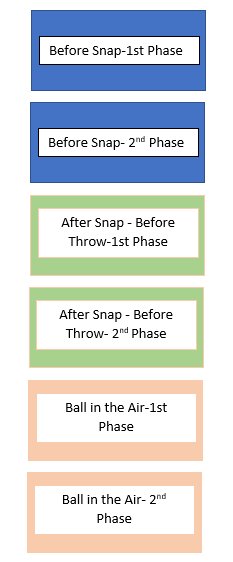

# Feature Importance for each Partition

We will loop through each partition and see which features will have the most influence on our predictions, for each partition.

In [ ]:


np.set_printoptions(suppress=True)

# Set the train dataset

Cols = ['X_std_X_Var', 'Y_std_Y_Var', 's_S_var', 'dx_Vardx', 'dy_Vardy', 'Opp_Dist_COpp_oppVar', 'Opp_Dist_COpp_oppMean', 'Team_Dist_CTm_mateVar', 'Team_Dist_CTm_mateMean', 'diffDir_oppDirVar', 'diffDir_oppDirMean', 'disRatio_ratVar', 'disRatio_ratMean', 'Diff_WR_DiffO_var', 'Diff_WR_DiffO_mean', 'Diff_QB_Diff_QBvar', 'Diff_QB_Diff_QBmean', 'Looking_AtQB_Looking_AtQBvar', 'Looking_AtQB_Looking_AtQBmean', 'WR', 'TE', 'RB', 'CB', 'FS', 'WRtoCBRatio']

Groups = ClustModel1['Group_']
Groups = Groups.drop_duplicates()
Groups = [ 'Before Snap-1st Phase','Before Snap-2nd Phase','After Snap - Before Throw-1st Phase','After Snap - Before Throw-2nd Phase','Ball in the Air-1st Phase',
 'Ball in the Air-2nd Phase']

#Groups = [ 'Before Snap-1st Phase']

data=[]
feat_imp = []

for g in Groups:
    grouped = ClustModel1[ClustModel1['Group_'] == g]
    X = grouped[Cols]
    y = grouped['Man']
    # Scale the data
    X[Cols] = SimpleImputer().fit_transform(X[Cols])
    X[Cols] = StandardScaler().fit_transform(X[Cols])
    df, feats = Predictions(X,y,g)
    feats['Group'] = g
    data.append(df)
    feat_imp.append(feats)

Final = pd.concat(data)

del Final
del data
gc.collect()

FinalFeats = pd.concat(feat_imp)
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

FinalFeats2 = FinalFeats.groupby(['Group','col'])['imp'].mean().reset_index()

import plotly.express as px


def change_name(x):
            return x.replace('Opp_Dist_COpp_oppVar','Opp. Distance Var').replace('Team_Dist_CTm_mateVar','Teammate Distance Var').replace('Diff_QB_Diff_QBvar','QB/Defender Orientation variance').replace('Diff_QB_Diff_QBmean','QB/Defender Orientation mean').replace('Opp_Dist_COpp_oppMean','Opp. Distance Mean').replace('Team_Dist_CTm_mateMean','Teammate Distance Mean')
    
Groups = [ 'Before Snap-1st Phase','Before Snap-2nd Phase','After Snap - Before Throw-1st Phase','After Snap - Before Throw-2nd Phase','Ball in the Air-1st Phase',
 'Ball in the Air-2nd Phase']

for g in Groups:
    print(g)
    grouped = FinalFeats2[FinalFeats2['Group'] == g].sort_values(by=['imp'], ascending=False).head(5)
    grouped['col'] = grouped['col'].map(lambda x: change_name(x))
    fig = px.bar(grouped, x='col', y='imp',color = 'col', template='plotly_dark',barmode='relative')
    fig.show()

del FinalFeats
del FinalFeats2
gc.collect()

It appears that "distance between defender and closest offensive player" mean has the greatest level of influence, with Defender/QB orientation difference and distance from closest teammate as close 2nd and 3rd features

# Splitting the Data

In [ ]:
ClustModel1.groupby(['gameId_'])['coverage_'].count().reset_index()

We will train/test the model on the first 9 games, then test the model again on a hold out set using the last 4 games: 2018090910, 2018090912, 2018091000, 2018091001

In [ ]:
Games = ['2018090910','2018090912','2018091000','2018091001']

#EntireData = ClustModel1.query('coverage_ == "None"')
#ClustModel1 #= #ClustModel1.query('coverage_ != "None"')
HoldOut = ClustModel1[(ClustModel1['gameId_'].isin(Games))]
Train = pd.concat([ClustModel1, HoldOut]).drop_duplicates(keep=False)

The train/test dataset and the hold out set have roughly the same Man/Zone distribution

In [ ]:
print(Train['Man'].value_counts(normalize=True))
print(HoldOut['Man'].value_counts(normalize=True))

In [ ]:
def MLPpredict(X_train, X_test, y_train, y_test,HoldX,Holdy,grouped,Holdgrouped,g):
    if g == 'Before Snap-1st Phase':
        MLPclf = MLPClassifier(max_iter=100,activation='logistic',alpha=0.0001,hidden_layer_sizes=(10, 120, 10),learning_rate='adaptive',solver='adam',random_state=65)
    elif g =='Before Snap-2nd Phase':
        MLPclf = MLPClassifier(max_iter=100,activation='logistic',alpha=0.0001,hidden_layer_sizes=(50, 100, 50),learning_rate='adaptive',solver='adam',random_state=65)
    elif g == "After Snap - Before Throw-1st Phase":
        MLPclf = MLPClassifier(max_iter=100,activation='tanh',alpha=0.05,hidden_layer_sizes=(100,),learning_rate='adaptive',solver='adam',random_state=65)
    elif g == "After Snap - Before Throw-2nd Phase":
        MLPclf = MLPClassifier(max_iter=100,activation='relu',alpha=0.01,hidden_layer_sizes=(100,),learning_rate='adaptive',solver='adam',random_state=65)
    elif g == "Ball in the Air-1st Phase":
        MLPclf = MLPClassifier(max_iter=100,activation='tanh',alpha=0.01,hidden_layer_sizes=(100,),learning_rate='constant',solver='adam',random_state=65)
    elif g == "Ball in the Air-2nd Phase":
        MLPclf = MLPClassifier(max_iter=100,activation='tanh',alpha= 0.001,hidden_layer_sizes=(100,),learning_rate='adaptive',solver='adam',random_state=65)
    else:
        MLPclf = MLPClassifier(max_iter=100,random_state=65)
    return MLPclf

# Model

We will train a model for each partition independently from one another, and gather the expected probabilities for each cornerback in each partition. Since the dataset is imbalanced with nearly 66% of the data favoring zone coverage, we will add in a decision threshold adjuster for each partition that levels the playing field. After we loop through each event, we append the predictions to the original dataset and then concatenate all the partitions back together. We will do this with the train/test dataset and compare results on the holdout to see how well the model performed.

# For Each Partition

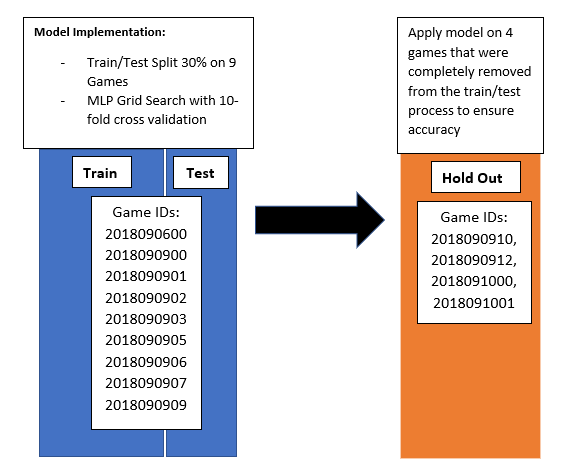

## Decision Threshold Adjuster

The default threshold for a binary classifier model is .5, in our case, indicating any probability below .5 is labeled Zone coverage and anything above .5 is labeled man coverage. With the threshold adjuster, you will see that in some cases the threshold could move down to around .3, meaning a .32 probability of man coverage will be labeled as man coverage. After incorporating this method, our recall and F1 scores vastly improve!

# Scoring

Instead of analyzing accuracy, we will instead focus on recall and F1 scores for the model, this is best practice when handling an imbalanced dataset.  

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report,auc,roc_auc_score,confusion_matrix,precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score,roc_curve,f1_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")
    
np.set_printoptions(suppress=True)

# Set the train dataset

Cols = ['X_std_X_Var', 'Y_std_Y_Var', 's_S_var', 'dx_Vardx', 'dy_Vardy', 'Opp_Dist_COpp_oppVar', 'Opp_Dist_COpp_oppMean', 'Team_Dist_CTm_mateVar', 'Team_Dist_CTm_mateMean', 'diffDir_oppDirVar', 'diffDir_oppDirMean', 'disRatio_ratVar', 'disRatio_ratMean', 'Diff_WR_DiffO_var', 'Diff_WR_DiffO_mean', 'Diff_QB_Diff_QBvar', 'Diff_QB_Diff_QBmean', 'Looking_AtQB_Looking_AtQBvar', 'Looking_AtQB_Looking_AtQBmean', 'Looking_AtQB_Looking_AtQBMax', 'WR', 'TE', 'RB', 'CB', 'FS', 'WRtoCBRatio']

Groups = ClustModel1['Group_']
Groups = Groups.drop_duplicates()
Groups = [ 'Before Snap-1st Phase','Before Snap-2nd Phase','After Snap - Before Throw-1st Phase','After Snap - Before Throw-2nd Phase','Ball in the Air-1st Phase',
 'Ball in the Air-2nd Phase']

data = []
HoldData = []

for g in Groups:
    print(g)
    grouped = Train[Train['Group_'] == g]
    Holdgrouped = HoldOut[HoldOut['Group_'] == g]

    X = grouped[Cols]
    y = grouped['Man']

    HoldX = Holdgrouped[Cols]
    Holdy = Holdgrouped['Man']

    HoldX[Cols] = SimpleImputer().fit_transform(HoldX[Cols])
    HoldX[Cols] = StandardScaler().fit_transform(HoldX[Cols])


    # Scale the data
    X[Cols] = SimpleImputer().fit_transform(X[Cols])
    X[Cols] = StandardScaler().fit_transform(X[Cols])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #MLP
    MLPclf = MLPpredict(X_train, X_test, y_train, y_test,HoldX,Holdy,grouped,Holdgrouped,g)
    MLPclf.fit(X_train, y_train)
    print('Best parameters found MLP:\n', MLPclf)
    y_true, y_pred = y_test, MLPclf.predict(X_test)

    y_scores = MLPclf.predict_proba(X_test)[:,1]
    predictions = MLPclf.predict(X_test)

    from sklearn.metrics import classification_report
    print("-------------------------------------------")
    false_pos_rate, true_pos_rate, proba = roc_curve(y_true, y_scores)
    optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
    print("Optimal Threshold: ", round(optimal_proba_cutoff,4))
    roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_scores]
    print("-------------------------------------------")
    print('Results on the test set:')
    print("-------------------------------------------")
    print("ROC Score Before and After Thresholding: {}, {}".format(round(roc_auc_score(y_test, predictions),3), round(roc_auc_score(y_test, roc_predictions),3)))
    print("Recall Score Before and After Thresholding: {}, {}".format(round(recall_score(y_test, predictions),3), round(recall_score(y_test, roc_predictions),3)))
    print("F1 Score Before and After Thresholding: {}, {}".format(round(f1_score(y_test, predictions),3), round(f1_score(y_test, roc_predictions),3)))


    grouped['MLPProb'] = MLPclf.predict_proba(X)[:,1]
    grouped['MLPPred'] = np.where(grouped['MLPProb'] > optimal_proba_cutoff,1,0)
    
    

    print("-------------------------------------------")
    #Hold Out
    print("Results on the Hold Out set:")
    predictions = MLPclf.predict(HoldX)
    Holdgrouped['MLPProb'] = MLPclf.predict_proba(HoldX)[:,1]
    Holdgrouped['MLPPred'] = np.where(Holdgrouped['MLPProb'] > optimal_proba_cutoff,1,0)
 #   print("MLP: ",roc_auc_score(Holdgrouped['Man'], Holdgrouped['MLPPred']))

    
    print("ROC Score Before and After Thresholding: {}, {}".format(round(roc_auc_score(Holdy, predictions),3), round(roc_auc_score(Holdy, Holdgrouped['MLPPred']),3)))
    print("Recall Score Before and After Thresholding: {}, {}".format(round(recall_score(Holdy, predictions),3), round(recall_score(Holdy, Holdgrouped['MLPPred']),3)))
    print("F1 Score Before and After Thresholding: {}, {}".format(round(f1_score(Holdy, predictions),3), round(f1_score(Holdy, Holdgrouped['MLPPred']),3)))

    #EntireDataGrouped['MLPProb'] = MLPclf.predict_proba(AllX)[:,1]
    print("-------------------------------------------")
    print("                                           ")
    print("-------------------------------------------")
    data.append(grouped)
    HoldData.append(Holdgrouped)

Final = pd.concat(data)
HoldFinal = pd.concat(HoldData)

# Train/Test Dataset

After we get the probabilites from the defenders, we average all the probabilities for each play to get a final probabilitiy prediction which is either Man or Zone. We also include a threshold adjuster for this situation as well.

In [ ]:
First = Final.groupby(['gameId_','playId_','Man'])['MLPProb'].mean().reset_index()
First['Pred'] = np.where(First['MLPProb'] > .5,1,0)


false_pos_rate, true_pos_rate, proba = roc_curve(First['Man'], First['MLPProb'])
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
print("Cutoff: ",optimal_proba_cutoff)
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in First['MLPProb']]

First['Pred'] = np.where(First['MLPProb'] > optimal_proba_cutoff,1,0)


print(classification_report(First['Man'], First['Pred']))
print("ROC_AUC Score:",roc_auc_score(First['Man'], First['Pred']))
print("Recall Score:",recall_score(First['Man'], First['Pred']))
print(confusion_matrix(First['Man'], First['Pred']))

You can see after adjusting the threshold cutoff to .34, we have an AUC score and Recall score of 87% for the concatenated train/test set. 

**However,** this is slightly overfitting because a good portion of this data was used to train the model on. The true test will be how well the hold out set did. 

In [ ]:
Second = HoldFinal.groupby(['gameId_','playId_','Man'])['MLPProb'].mean().reset_index()
Second['Pred'] = np.where(Second['MLPProb'] > .5,1,0)


Second['Pred'] = np.where(Second['MLPProb'] > optimal_proba_cutoff,1,0)




print(classification_report(Second['Man'], Second['Pred']))
print("ROC_AUC Score:",roc_auc_score(Second['Man'], Second['Pred']))
print("Recall Score:",recall_score(Second['Man'], Second['Pred']))
print(confusion_matrix(Second['Man'], Second['Pred']))

The holdout set peformed pretty well! We applied the same .34 cutoff threshold and received An AUC score of 81% and a recall score of 80%, these metrics prove that this model can be quite useful in predicting Man/Zone coverages

We will concatenate all data together and append the results back to the original dataset

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
All = pd.concat([First,Second])

print(classification_report(All['Man'], All['Pred']))

fpr, tpr, thresholds = roc_curve(All['Man'], All['Pred'])
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

import math

def round_half_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n*multiplier - 0.5) / multiplier

All['Code'] = All['gameId_'].astype(str) + "-" + All['playId_'].astype(str)
All = All.set_index('Code')
All = All.loc[~All.index.duplicated(keep='first')]

AllDetail = pd.concat([Final,HoldFinal])
Cols = ['gameId_','playId_','Group_','nflId_','MLPProb','MLPPred']
AllDetails = AllDetail[Cols]
AllDetails['Code'] = AllDetails['gameId_'].astype(str) + "-" + AllDetails['playId_'].astype(str)
AllDetails['PlayPredProb'] = AllDetails.Code.map(All['MLPProb'])
AllDetails['PlayPred'] = AllDetails.Code.map(All['Pred'])

AllDetails['Code'] = AllDetails['gameId_'].astype(str) + "-" + AllDetails['playId_'].astype(str) + "-" + AllDetails['Group_'].astype(str) + "-" + AllDetails['nflId_'].astype(str)
AllDetails = AllDetails.set_index('Code')
AllDetails = AllDetails.loc[~AllDetails.index.duplicated(keep='first')]
AllDetails[['MLPProb']] = MinMaxScaler().fit_transform(AllDetails[['MLPProb']])
AllDetails[['PlayPredProb']] = MinMaxScaler().fit_transform(AllDetails[['PlayPredProb']])


Finaldf1['Code'] = Finaldf1['gameId'].astype(str) + "-" + Finaldf1['playId'].astype(str) + "-" + Finaldf1['Group'].astype(str) + "-" + Finaldf1['nflId'].astype(str)

Finaldf1['PlayerPredProb'] = Finaldf1.Code.map(AllDetails['MLPProb'])
Finaldf1['PlayerPred'] = Finaldf1.Code.map(AllDetails['MLPPred'])
Finaldf1['PlayPredProb'] = Finaldf1.Code.map(AllDetails['PlayPredProb'])
Finaldf1['PlayPred'] = Finaldf1.Code.map(AllDetails['PlayPred'])

Finaldf1['PlayerPredProb'] = Finaldf1['PlayerPredProb'].map(lambda x: np.around(x, decimals=4))
Finaldf1['PlayPredProb'] = Finaldf1['PlayPredProb'].map(lambda x: np.around(x, decimals=4))

# Man Coverage

Here is an example of predicted man coverage play

In [ ]:
import math
#from BDBUtils.Utilities import AnimatePlay
#sns
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
pd.set_option('max_columns', 1000)

#pd.options.display.float_format = '{:.4f}'.format

gId = 2018090902	
pId = 2043
nflId = [2543474,2533060,2556367]



Finaldf1['NewPlayerPredProb'] = np.where(Finaldf1['PlayerPredProb'] > .5,"Man " + (round(Finaldf1['PlayerPredProb'],2)).astype(str), "Zone " + round((1 - Finaldf1['PlayerPredProb']),2).astype(str)) 


ex = Finaldf1.query('gameId == @gId & playId == @pId')


One = ex.query('position == "CB" | OnOffense == True | displayName == "Football"')

from matplotlib.patches import Polygon


animated_play = AnimatePlay(One,player_id=nflId, Tri = False, MPH = False,Text="",Show='NewPlayerPredProb',method='single' )
HTML(animated_play.ani.to_jshtml())

# Zone Coverage

Here is an example of Zone coverage prediction

In [ ]:
gId = 2018090600	
pId = 4142
nflId = [2555383,2557958,2552689]

Finaldf1['CoveragePred'] = np.where(Finaldf1['PlayerPred'] == 1,"Man","Zone")
ex = Finaldf1.query('gameId == @gId & playId == @pId')

One = ex.query('position == "CB" | OnOffense == True | displayName == "Football"')
two = One.query('After_PassArrived == 0')
#two.filter(['event','displayName','Orientation_std','QBslope1','WRslope1','Def_Or','Diff_QB','Diff_WR',	'DIFFQB','DIFFWR','Player_POV'], axis=1).head(70)
from matplotlib.patches import Polygon


animated_play = AnimatePlay(two,player_id=nflId, Tri = False, MPH = False,Text="",Show='NewPlayerPredProb',method='single' )
HTML(animated_play.ani.to_jshtml())

# Final Thoughts:

Even with only 9 games to train and test the model on, it was still able to make solid predictions on 4 out of sample games using only certain features of the cornerbacks throughout the play. With the addition of more coverage label data and fine tuning hyperparameters, this model could vastly improve.

---------------------------------------------------------------------------------------------------------------------------------------

# Other Work:

1. [Shadow Cornerback + Coverage Analysis](https://www.kaggle.com/jdruzzi/shadow-cornerback-coverage-analysis)

2. [Defender Bite Velocity on Play-Action](https://www.kaggle.com/jdruzzi/defender-bite-velocity-on-play-action)

3. [Pass Coverage Classification](https://www.kaggle.com/jdruzzi/pass-coverage-classification-80-recall)

4. [Quantifying Press Coverage](https://www.kaggle.com/jdruzzi/quantifying-press-coverage-ability)

5. [Defender Tendencies: One-Cut Routes + Double Moves](https://www.kaggle.com/jdruzzi/defender-tendencies-one-cut-routes-double-moves)

## Data:

[Revised BDB Data](https://www.kaggle.com/jdruzzi/revised-bdb-data)
